# HoG classifier
The current exercise builds on the HOG exercises from the previous exercise
, but it can also be successfully completed independently.

<article class="message">
    <div class="message-body">
        <strong>List of individual tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#sklearn">Task 1: Implement a classifier</a>
            </li>
            <li>
            <a href="#sliding">Task 2: Sliding window</a>
            </li>
            <li>
            <a href="#calc_hog">Task 3: Classifying the test image</a>
            </li>
            <li>
            <a href="#reflect">Task 4: Reflections</a>
            </li>
        </ul>
    </div>
</article>

The cell below imports the necessary libraries, loads an example image and extracts and plots the HOG features along the original image. 


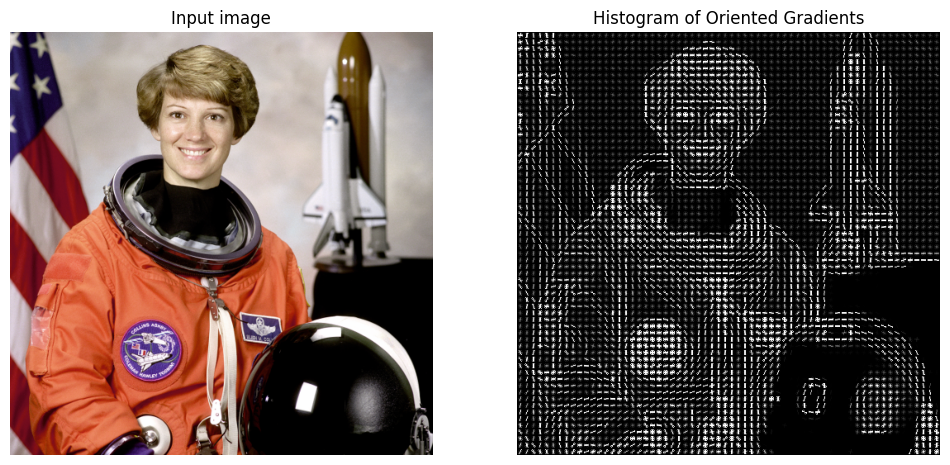

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import chain

from skimage import data, transform, feature, exposure
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_people
from skimage.color import rgb2gray
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.svm import LinearSVC
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Creating the training data
Through the following steps you will construct the training data, which comprises of HOG features extracted from images containing faces and non-faces. The constructed set will be used for training a binary classification model.
**Face Images (Positive class)**
You will use the "Labeled Faces in the Wild" dataset ("LFW") for the images containing faces as provided by scikit-learn. The cell below loads the dataset, extracts the facial images, and displays a selection of these images for visualization. 
<article class="message is-info">
  <div class="message-header">Info</div>
  <div class="message-body">

  When first loading the dataset, please be aware that the code may require a few minutes to finish execution.


  </div>
</article>


(13233, 62, 47)


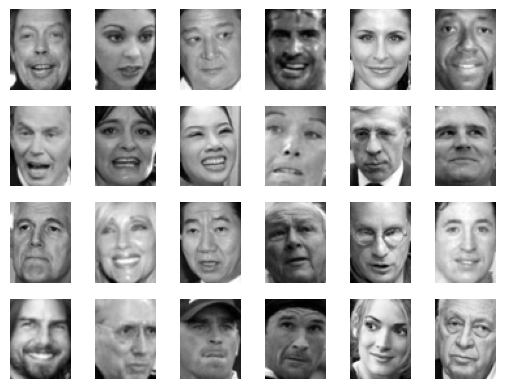

In [2]:
faces = fetch_lfw_people()

face_images = faces.images
print(face_images.shape) # 13233 face images to use for training

# Visualize Positive Set (face images)

fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(face_images[500 * i], cmap='gray')
    axi.axis('off')

**Non-face Images (Negative class)**
For non-face images other images from the Scikit-Image library are used. The cell below loads these images. The `PatchExtractor`
 method is used for data augmentation.


In [3]:
# negative data samples
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
# images = []

images = [data.camera(), data.coins(),data.text(),data.moon(),data.page(),data.clock(),data.coffee(),data.hubble_deep_field()]
img = []
for im in images:
    if len(im.shape)==3:
        img.append(rgb2gray(im))
    else:
        img.append(im)

### Make patches of the different negative samples to generate a larger dataset

def extract_patches(img, N, scale=1.0, patch_size=face_images[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

non_face_images = np.vstack([extract_patches(im, 1000, scale)
                              for im in img for scale in [0.5,1.0,2.0]]) # [0.5, 1.0, 2.0]
print(non_face_images.shape)

(24000, 62, 47)


The cell below visualizes the newly created non-face image patches:


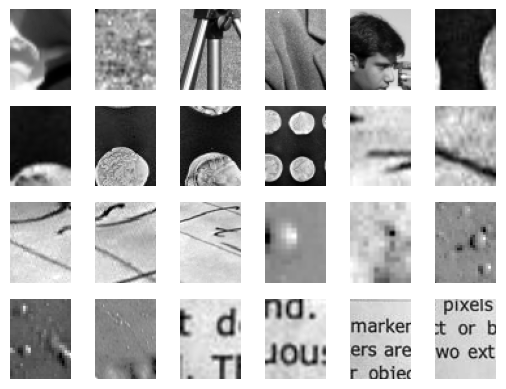

In [4]:
# Visualize Negative Set

fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(non_face_images[600 * i], cmap='gray')
    axi.axis('off')

The cell below combines the face and the non face images, then extracts the HOG features from the combined set. It also creates the target labels for the newly assembled training dataset. 


In [5]:
X_train = np.array([hog(im, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
                    for im in chain(face_images, non_face_images)])


Y_train = np.zeros(X_train.shape[0])
Y_train[:face_images.shape[0]] = 1

## Training a classifier
In the following task you will train a linear classifier using HoG features.
<article class="message task"><a class="anchor" id="sklearn"></a>
    <div class="message-header">
        <span>Task 1: Implement a classifier</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


The cell below contains the classification model. Your task is to:
1. Fit the model to the training data.

2. Calculate and print the accuracy of the classifier on the training data.

3. Construct and plot a confusion matrix of the model predictions on the training set.

4. Based on the accuracy and the confusion matrix, discuss how effective the model is. 




</div></article>



Accuracy: 0.9962


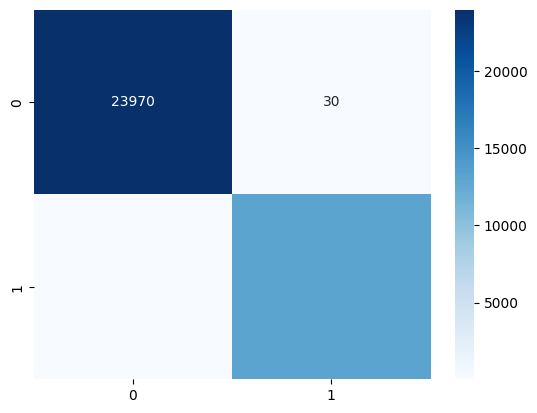

In [9]:
model = LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0)

def accuracy(pred, actual):
    return np.sum(pred == actual) / len(actual)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_train)

conf_matrix = confusion_matrix(Y_train, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

temp_acc = accuracy(Y_pred, Y_train)
print(f"Accuracy: {temp_acc:.4f}")

## Testing on new images
In this section you will evaluate the trained model on a novel image. You will implement a function that slides over the image and breaks it down to smaller patches. Then you will extract the HOG features from these patches, and categorize them as either a face (1) or a non-face (0) image. 


(120, 100)


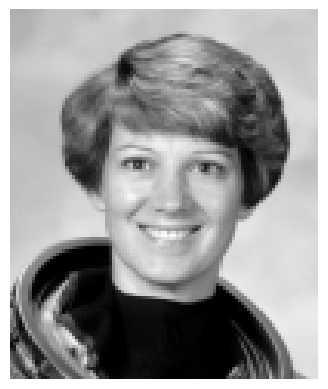

In [10]:
# Load a test image
test_img = data.astronaut()
test_img = rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:120, 60:160]


plt.imshow(test_img, cmap='gray')
plt.axis('off')
print(test_img.shape)

<article class="message task"><a class="anchor" id="sliding"></a>
    <div class="message-header">
        <span>Task 2: Sliding window</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights hard"></i>
        </span>
    </div>
<div class="message-body">


1. Implement the method `sliding_windows`
 that takes the test image and extracts image patches from it. 
    - The function should iteratively slide over the entire image and extract image patches of the same size as the inputs the classifier was trained on.
    - The function should return a tuple of the coordinates of the upper left corner of each subimage patch, and the patch itself.





</div></article>



In [17]:
# Sliding Window function - Goes Over the image patch by patch
# and computes the HOG features for each patch.

def sliding_window(img, patch_size, istep, jstep):
    indices = []  # Fix the spelling from 'indicies' to 'indices'
    patches = []
    
    for i in range(0, img.shape[0] - patch_size[0] + 1, istep):
        for j in range(0, img.shape[1] - patch_size[1] + 1, jstep):
            # Extract the patch
            patch = img[i:i + patch_size[0], j:j + patch_size[1]]
            # Append the coordinates and patch to the respective lists
            indices.append((i, j))  # Correctly references 'indices'
            patches.append(patch)

    return indices, patches  # Return the corrected 'indices'

# Write you code iterating over the test image here.
# EASIEST approach is to use a foor loop for each image dimension

<article class="message task"><a class="anchor" id="calc_hog"></a>
    <div class="message-header">
        <span>Task 3: Classifying the test image</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


In the following task you have to:
1. Extract the HOG features for all patches from the test image (`test_img`
) by making use of the `sliding_window`
 and `hog`
 functions. Store the features in an array called `hog_patches`
 and the corresponding indices in an array called `indices`
.

2. Use the model to classify the extracted HOG patches and store the results in an array called `labels`
.

3. Use the existing code to visualize the detections. 




</div></article>



HOG feature vector length: 768


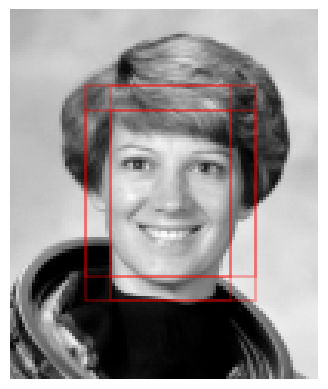

In [30]:
# Apply sliding window function to test_img

patch_size = face_images[0].shape  # Match training patch size
hog_params = {
    'orientations': 8,  # Match the number of orientations during training
    'pixels_per_cell': (8, 8),  # Match training pixels per cell
    'cells_per_block': (2, 2),  # Match training cells per block
    'visualize': False
}

# Apply sliding window to test image
indices, patches = sliding_window(test_img, patch_size, 8, 8)

# Extract HOG features
hog_patches = np.array([hog(patch, **hog_params) for patch in patches])
print(f"HOG feature vector length: {hog_patches.shape[1]}")  # Debugging

# Check if the feature vector length matches the model's input
expected_feature_length = X_train.shape[1]  # Ensure this matches the training feature length
if hog_patches.shape[1] != expected_feature_length:
    raise ValueError(f"Feature length mismatch! HOG features: {hog_patches.shape[1]}, expected: {expected_feature_length}")

# Predict labels using the classifier
labels = model.predict(hog_patches)

# Visualize the detections
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

Ni, Nj = face_images[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

## Reflections
<article class="message task"><a class="anchor" id="reflect"></a>
    <div class="message-header">
        <span>Task 4: Reflections</span>
        <span class="has-text-right">
          <i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


- Summarize the overall process of face detection implemented in this exercise. 
- There are multiple overlapping boxes of the same detected face in the test image. How could you ensure that a face is only detected once? 
- How could the face detection pipeline be improved? Consider the following steps: training data construction, model fitting, test images.



</div></article>



In [ ]:
# This code implements a face detection pipeline using a sliding window approach and HOG features with a trained model.
# 
# Sliding Window and HOG Extraction:
# - A sliding window extracts overlapping patches from the test image (`test_img`), matching the training patch size.
# - HOG features are calculated for each patch using specified parameters: orientations, pixels per cell, and cells per block.
# - The extracted HOG features are stored in `hog_patches` and their length is checked against the training feature length.
# 
# Classification and Visualization:
# - The trained model (`model`) predicts labels for `hog_patches`, classifying each patch as face (`1`) or non-face (`0`).
# - Positive detections (`labels == 1`) are visualized by overlaying rectangles on the corresponding regions of the test image.
# 
# Key Points:
# - Ensures consistent parameters between training and testing (patch size, HOG settings) for reliable predictions.
# - Visualization validates the pipeline by highlighting detected faces, providing interpretable results.